# Baseline Neural Network


### Focus on Electrode 5

In [3]:
# Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../../')
from brain2brain import utils, generators, models
%matplotlib inline

# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed

from scipy.stats import pearsonr

from brain2brain import utils, models

In [5]:
train_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
total_electrode_count = utils.get_file_shape(train_bin_norm_paths[0])[1]
# Electrodes
electrode_count = 1
electrode = 5
# Training Generator
train_generator = generators.FGenerator(file_paths=train_bin_norm_paths,
                                        lookback=50,
                                        length=10,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_bin_norm_paths,
                                        lookback=50,
                                        length=10,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=False)

(5429, 114)


In [6]:
train_generator[0][1][1023]

array([[-1.38574495],
       [-1.20068957],
       [-0.50224925],
       [-1.58157853],
       [-1.06601168],
       [-0.41627999],
       [ 0.5686695 ],
       [-0.18370858],
       [-0.05598361],
       [ 0.80823538]])

In [7]:
hidden_units = 256
output_dim = 10
input_len = 50
model = models.define_baseline_nn_model_o2o(hidden_units,input_len, output_dim)
model.compile(optimizer=RMSprop(), loss='logcosh')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50, 256)           512       
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                128010    
_________________________________________________________________
reshape (Reshape)            (None, 10, 1)             0         
Total params: 128,522
Trainable params: 128,522
Non-trainable params: 0
_________________________________________________________________


In [8]:
callback_list = [
#         EarlyStopping(
#             monitor="val_loss",
#             patience=5,
#             mode="min"
#         )
]
history = model.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=50,
                              validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 8 steps
Epoch 1/50
25/25 [==============================] - 4s 160ms/step - loss: 0.2742 - val_loss: 0.2259
Epoch 2/50
25/25 [==============================] - 4s 152ms/step - loss: 0.2400 - val_loss: 0.2214
Epoch 3/50
25/25 [==============================] - 3s 135ms/step - loss: 0.2359 - val_loss: 0.2323
Epoch 4/50
25/25 [==============================] - 3s 138ms/step - loss: 0.2369 - val_loss: 0.2201
Epoch 5/50
25/25 [==============================] - 4s 145ms/step - loss: 0.2330 - val_loss: 0.2201
Epoch 6/50
25/25 [==============================] - 4s 158ms/step - loss: 0.2328 - val_loss: 0.2200
Epoch 7/50
25/25 [==============================] - 3s 135ms/step - loss: 0.2286 - val_loss: 0.2212
Epoch 8/50
25/25 [==============================] - 3s 135ms/step - loss: 0.2300 - val_loss: 0.2178
Epoch 9/50
25/25 [===============

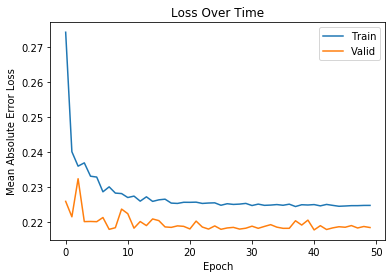

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

# Evaluate Sequences

In [10]:
val_generator[0][1].shape

(1024, 10, 1)

In [11]:
def predict_and_plot(model,
                     input_sequnece_batch,
                     target_sequence_batch,
                     sample_ix,
                     pred_steps: int,
                     enc_tail_len=50):
    input_sequence = input_sequnece_batch[sample_ix]
    target_sequence = target_sequence_batch[sample_ix]
    pred_series = models.predict_sequence_o2o(input_sequence,
                                              pred_steps, model)
    input_sequence = input_sequence.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_sequnece = target_sequence.reshape(pred_steps,1)
    print(target_sequence.shape)
    input_sequence_tail = np.concatenate([input_sequence[-enc_tail_len:],target_sequence[:1]])
    x_encode = input_sequence_tail.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), target_sequence.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_sequence.reshape(-1)))
    print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1), input_sequence_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_sequence,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])


(10, 1)
Correlation: 0.41341540818655476. P: 0.23501255782455235. MAE: 0.6272175351558749


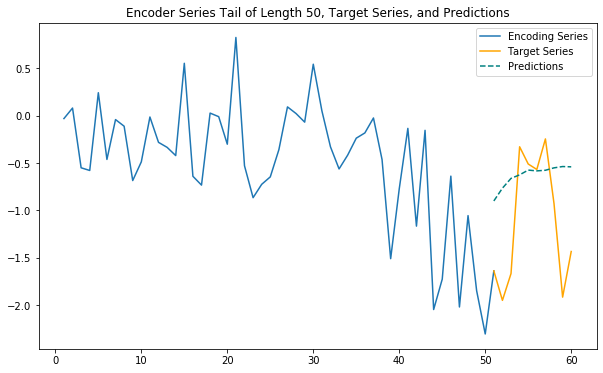

In [12]:
predict_and_plot(model, val_generator[0][0], val_generator[0][1],
                 0, pred_steps = 10)

(10, 1)
Correlation: 0.010912217897623366. P: 0.9761323655586758. MAE: 0.5769768316504219


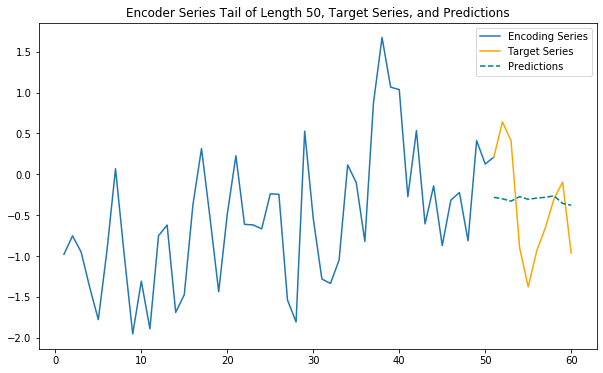

In [13]:
predict_and_plot(model, val_generator[0][0], val_generator[0][1],
                 1, pred_steps = 10)

In [14]:
def get_corr_mae(model,
                 input_sequnece_batch,
                 target_sequence_batch,
                 sample_ix,
                 pred_steps: int,
                 enc_tail_len=50,
                 verbose=True):
    input_sequence = input_sequnece_batch[sample_ix]
    target_sequence = target_sequence_batch[sample_ix]
    pred_series = models.predict_sequence_o2o(input_sequence,
                                              pred_steps, model)
    input_sequence = input_sequence.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_sequnece = target_sequence.reshape(pred_steps,1)
    input_sequence_tail = np.concatenate([input_sequence[-enc_tail_len:],target_sequence[:1]])
    x_encode = input_sequence_tail.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), target_sequence.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_sequence.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    return r, mae

In [15]:
get_corr_mae(model, val_generator[0][0], val_generator[0][1],
                 1, pred_steps = 10)

Correlation: 0.010912217897623366. P: 0.9761323655586758. MAE: 0.5769768316504219


(0.010912217897623366, 0.5769768316504219)

In [16]:
print("Calculating MAE/CORR per batch.")
batch_ix = 0
val_batch = val_generator[batch_ix] 
n_rows = val_batch[0][0].shape[0]
r_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(model, val_batch[0], val_batch[1],
                                sample_ix=sample_ix, pred_steps=10, verbose=False)
    r_array[sample_ix] = r
    sample_maes[sample_ix] = mae
z_mean = np.mean(r_array)
batch_r = np.tanh(z_mean)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Batch Mae: {batch_mae}")

Calculating MAE/CORR per batch.
Batch_r: 0.11673080509490216
Batch Mae: 0.5509550741922528


In [17]:
k = 5
top_k_r = np.abs(r_array).argsort()[:k]
print(top_k_r)

[47  1 11 44  8]


(10, 1)
Correlation: 0.006625301304154202. P: 0.9855077895383646. MAE: 0.47163382746296645
(10, 1)
Correlation: 0.010912217897623366. P: 0.9761323655586758. MAE: 0.5769768316504219
(10, 1)
Correlation: -0.03010559490324595. P: 0.9342036670648213. MAE: 0.5396821056493191
(10, 1)
Correlation: 0.03781213507308982. P: 0.9174041141431213. MAE: 0.4412581912344116
(10, 1)
Correlation: 0.06627277053968673. P: 0.8556633655221999. MAE: 0.42424952590322373


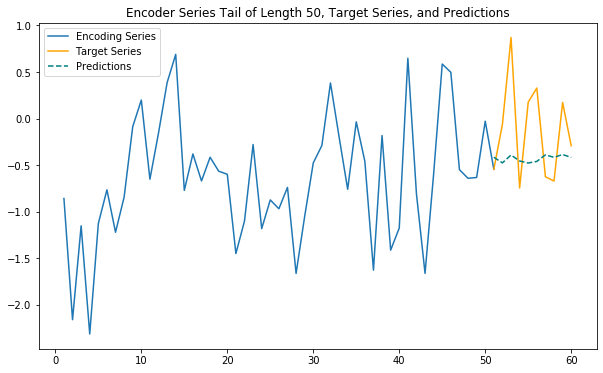

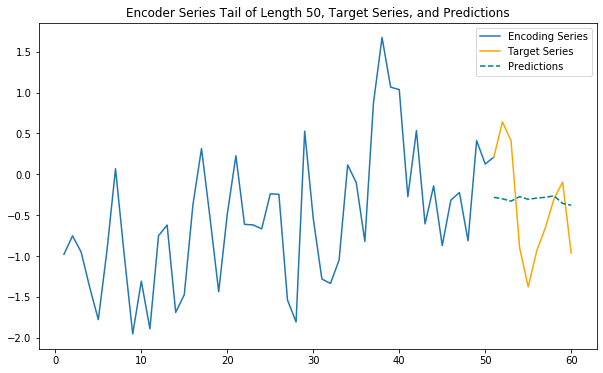

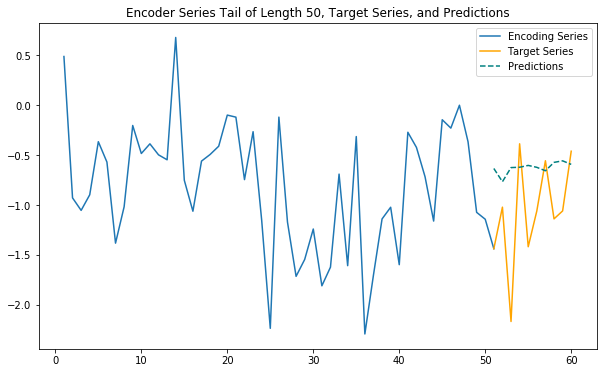

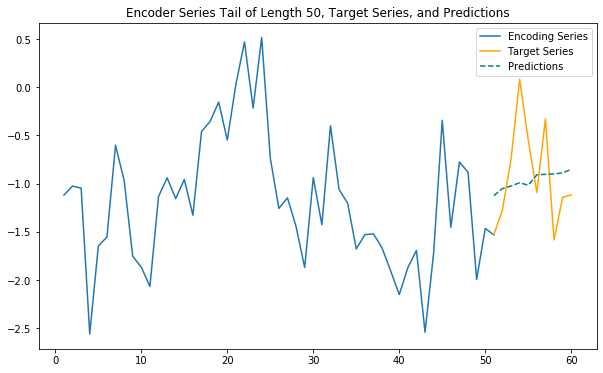

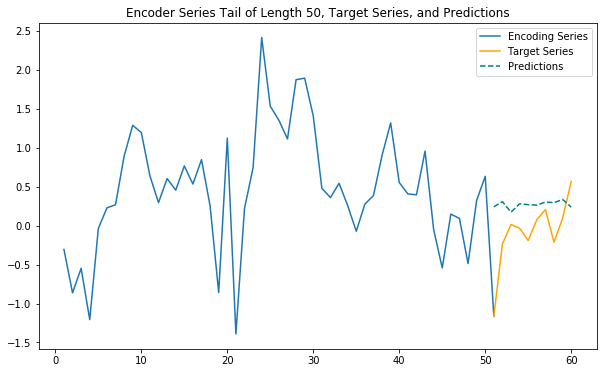

In [18]:
for i in top_k_r:
    predict_and_plot(model, val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=10)

In [19]:
k = 5
top_k_mae = sample_maes.argsort()[:k]
print(top_k_mae)

[37 46 34 43 17]


(10, 1)
Correlation: 0.5620824115221842. P: 0.09080797821250289. MAE: 0.29106042969960116
(10, 1)
Correlation: 0.5274948443714444. P: 0.1171252974334939. MAE: 0.33474811914440955
(10, 1)
Correlation: -0.1763294983677413. P: 0.6260500144963708. MAE: 0.3592902882061672
(10, 1)
Correlation: -0.17595120384161012. P: 0.6268028762800685. MAE: 0.3747450276471264
(10, 1)
Correlation: 0.33226179798694055. P: 0.34824174512302897. MAE: 0.37922107227648294


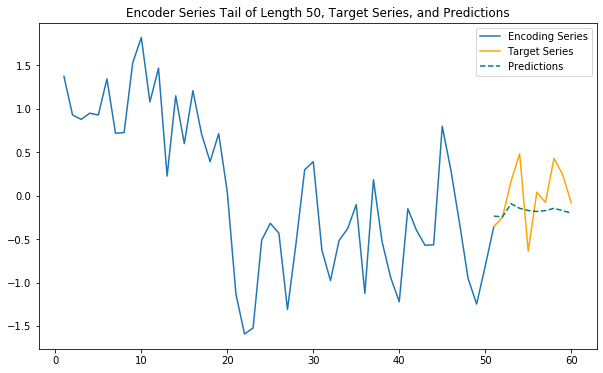

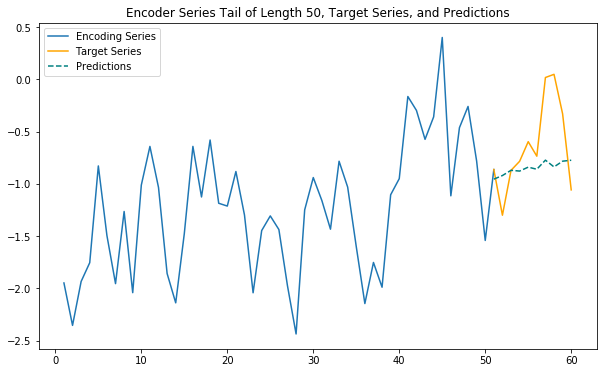

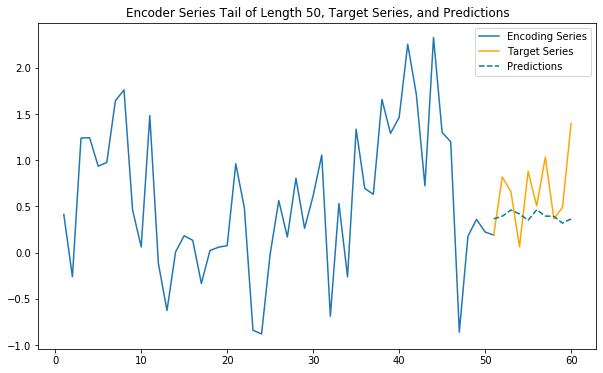

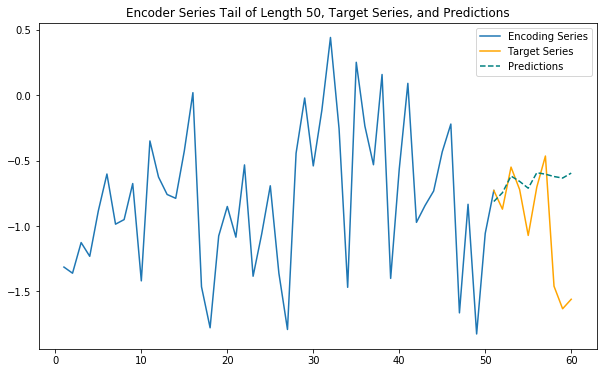

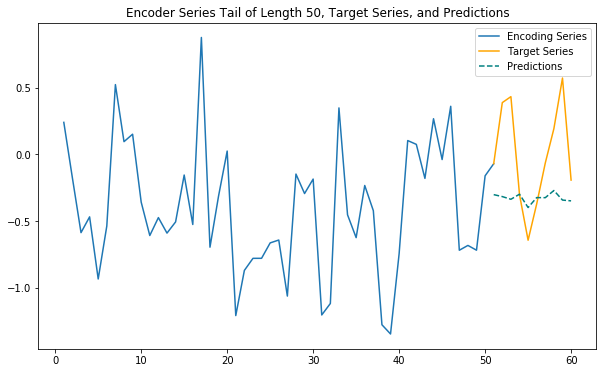

In [20]:
for i in top_k_mae:
    predict_and_plot(model, val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=10)